<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/Crank_em_vull_matar_Nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Crank-Nicolson  
Per aquest mètode resoldrem l'equació diferencial de forma numèrica utilitzant la mitjana temporal de la segona derivada numèrica espaial, és a dir farem la derivada segona al següent temps més la derivada segona al temps anterior dividint entre dos.\
Per la derivada temporal utilitzarem la derivada per la dreta (notem que el superindex i es refereix al temps i el superindex n a l'espai).\
Finalment després d'operar i reordenar termes ens queda, on hem definit $γ = \frac{Δt}{2Δx}$:\\

$T_{i+1}^n (1+2\gamma)-\gamma·T_{i+1}^{n+1}-\gamma · T_{i+1}^{n-1} = T_i^n (1-2\gamma) + \gamma · T_i^{n+1} + \gamma ·T_i
^{n-1} + Δt$\\

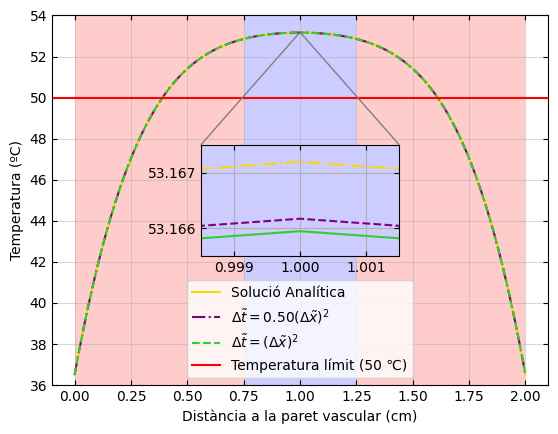

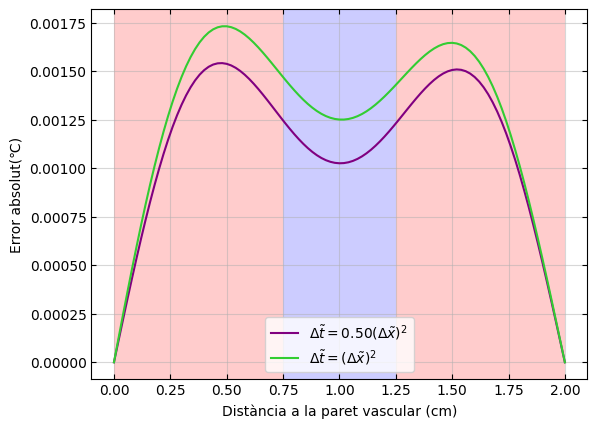

In [ ]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset # Per fer el Zoom

# CÀLCULS PREVIS
    # Dades de l'enunciat
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40
    # Amb aquests, calculem la difusivitat, que farem servir per a la normalització
alpha= kappa/(C_v*rho)

    # Imposem la nostra normalització
N= 101
x_0= 0.02 # Longitud de referència, triada per tal de normalitzar x_f,
x_f= 0.02/x_0 # Longitud final normalitzada

t_i= 0 #Temps inicial
t_0= x_0**2/alpha #Temps de referència, surt de la normalització de l'equació diferencial
t_f= 0.025 # Temps final ja normalitzat, ho diu l'enunciat

P_ext= volts**2*sigma/(2*(x_0)**2) # Calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 # Temperatura de referència, en kelvin
T_init= 309.65/T_0 # Temperatura inicial 36.5℃ normalitzada i en kelvins

    # Definim els dos casos a considerar de discretitzacions
dx= x_f/(N-1) # Valor de les particions espacials donat un nombre N de nodes espaials
dt_1= dx**2
dt_2= 0.5*dx**2



def gauss_seidel(A, b, x0, err):
    #Resol una equació lineal algebraica de l'estil Ax=b on A matriu b i x vectors
    #el vector x és el de les incògnites

    n = len(A[0])
    x = x0.copy() # Copiem x0 per evitar que x0 i x apuntin al mateix objecte i evitar que quan modifiquis un es modifiqui també l'altre

    while True:
        x_ant = x.copy()
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i]) # Part del sumatori que utilitza els x_i+1 (nous ja calculats)
            sum2 = np.dot(A[i, i+1:], x_ant[i+1:]) # Part del sumatori que utilitza els x_1 ("anteriors")

            # Ens assegurem que la diagonal de A to tingui 0 (per evitar dividir per 0 en l'esquema d'iteració)
            if A[i, i] == 0:
                print ("Algun element de la diagonal de A és 0")
                break
            x[i] = (b[i] - sum1 - sum2) / A[i, i]

        # Mirem la convergència tal com hem vist a teoria
        if np.abs(max(x - x_ant)) < err: #on err és l'error màxim que tolerem
            return np.array(x)



def CN(N, T_i, t_f, dt, dx):
  """
    N = int, nombre de nodes espaials
    T_i = float, temperatura inicial normalitzada
    t_f = float, temps final normalitzat
    dt = float, partició temporal
    dx = dx, partició espaial
  """
  gamma= dt/(2 * dx**2) #variable per simplificar notació

  dt_vect= np.ones((N-2, 1)) * dt
  dt_vect[0]= 2 * gamma * T_i + dt
  dt_vect[-1]= 2 * gamma * T_i + dt  #Vector dels dts que queden sumant a la solució

  T_i_vect = np.ones((N-2, 1)) * T_i
  fila1_A= (N-2) * [0]
  fila1_A [0]= 1 + 2 * gamma
  fila1_A [1]= -gamma
  col_A = (N-2) * [0]
  col_A [1]= -gamma
  A = toeplitz(fila1_A, col_A) #Funció que crea una matriu tridiagonal a partir de la primera fila i columna

  fila1_B= (N-2) * [0]
  fila1_B [0]= 1 - 2 * gamma
  fila1_B [1]= gamma
  col_B = (N-2) * [0]
  col_B [1]= gamma
  B = toeplitz(fila1_B, col_B)   #Una altra matriu tridiagonal

  inicial= np.array(99 * [T_init])  #Creem el nostre primer vector columna per                               #gauss-seidel a partir de la condició inicial
                                  #de temperatura (és bona aproximació)

  t = int(t_f/dt)

  for i in range(t):    #Bucle del càlcul del mètode de Crank-Nicolson, s'atura al arribar al temps final
    b = np.matmul(B, T_i_vect) + dt_vect  #Terme independent per Gauss-Seidel de l'equació Ax=b
    T_i_vect = gauss_seidel(A, b, T_i_vect, 1e-8)   #Cridem la funció gauss-seidel per trobar el temps següent

  T_i_vect =np.append(T_i_vect,[T_init])    #Afegim les condicions dels extrems i ara el vector té N components
  T_i_vect =np.append([T_init],T_i_vect)

  return T_i_vect

T1=(CN(101, T_init, t_f, dt_1, dx) * T_0)-273.15    #Cridem Crank-Nicolson per les dues discretitzacions proposades i desnormalitzem
T2=(CN(101, T_init, t_f, dt_2, dx) * T_0)-273.15


# PLOTS
x= np.linspace(0, 2, 101) #Eix de les x

# Solució analítica en ºC prèviament calculada
T_real_analitica =[36.5, 37.66969107552376, 38.774358434195335, 39.81640154529612, 40.79821064375386, 41.72216161151641, 42.590611364820006, 43.40589332815745,
                   44.17031304193472, 44.88614393046629, 45.55562325343692, 46.180948261775995, 46.76427257678938, 47.307702809179034, 47.813295432258144,
                   48.28305392123838, 48.71892616796447, 49.12280217792255, 49.496512053786034, 49.84182426721014, 50.16044421807828, 50.45401307796095,
                   50.72410691220182, 50.97223607281086, 51.19984485225365, 51.40831138628192, 51.59894779218382, 51.77300052724229, 51.931650950796836,
                   52.0760160721066, 52.207149465221676, 52.32604233127694, 52.433624688043835, 52.53076666618608, 52.6182798914777, 52.6969189322416,
                   52.76738279144132, 52.83031642321015, 52.886312254103814, 52.93591169002019, 52.979606590514436, 53.01784069315329, 53.05101097157308,
                   53.07946891202897, 53.1035216944332, 53.12343326516634, 53.139425290298334, 53.15167797926523, 53.16033077050395, 53.165482872043015,
                   53.16719365156882, 53.165482872043015, 53.16033077050395, 53.15167797926523, 53.139425290298334, 53.12343326516634, 53.1035216944332,
                   53.07946891202897, 53.05101097157308, 53.01784069315329, 52.979606590514436, 52.93591169002019, 52.886312254103814, 52.83031642321015,
                   52.76738279144132, 52.6969189322416, 52.6182798914777, 52.53076666618608, 52.433624688043835, 52.32604233127694, 52.207149465221676,
                   52.0760160721066, 51.931650950796836, 51.77300052724229, 51.59894779218382, 51.40831138628192, 51.19984485225365, 50.97223607281086,
                   50.72410691220182, 50.45401307796095, 50.16044421807828, 49.84182426721014, 49.496512053786034, 49.12280217792255, 48.718926167964526,
                   48.28305392123838, 47.813295432258144, 47.307702809179034, 46.76427257678938, 46.180948261775995, 45.55562325343692, 44.88614393046629,
                   44.17031304193472, 43.40589332815745, 42.590611364820006, 41.72216161151641, 40.79821064375386, 39.81640154529612, 38.774358434195335,
                   37.66969107552376, 36.5]



fig, ax= plt.subplots()
# Canviem el color del fons per representar les parets vasculars
plt.axvspan(0, 0.75,  facecolor='red',  alpha=0.2)
plt.axvspan(0.75, 1.25, facecolor='blue',  alpha=0.2)
plt.axvspan(1.25, 2,  facecolor='red',  alpha=0.2)

#REPRESENTACIÓ DELS RESULTATS
plt.plot(x, T_real_analitica, color="gold", label="Solució Analítica")
plt.plot(x, T2, color="purple", label=r"$\Delta \tilde{t}= 0.50(\Delta \tilde{x})^2$", linestyle="-.")
plt.plot(x, T1, color="limegreen", label=r"$\Delta \tilde{t}= (\Delta \tilde{x})^2$", linestyle="--")
ax.axhline(y=50, color='red',label="Temperatura límit (50 ℃)")

plt.xlabel("Distància a la paret vascular (cm)")
plt.ylabel("Temperatura (ºC)")
ax.tick_params(direction='in', top=True, right=True)
plt.xlim(-0.1,2.1)
plt.ylim(36,54)
plt.grid("equal", alpha=0.5)
plt.legend()


# ZOOM per poder visualitzar les diferències
axins1 = inset_axes(
    ax,
    width="40%",
    height="30%",
    loc='center'
)
axins1.set_facecolor("#CCCCFF")

axins1.plot(x, T1, color="limegreen")
axins1.plot(x, T2, color="purple", linestyle="--")
axins1.plot(x, T_real_analitica, "-.", color="gold")

axins1.set_xlim(0.9985, 1.0015)
axins1.set_ylim(53.1655, 53.1675)
axins1.grid()
axins1.set_xticks([0.999, 1, 1.001])
axins1.set_yticks([53.166, 53.167])

axins1.ticklabel_format(style='plain', axis='y')
axins1.yaxis.get_major_formatter().set_useOffset(False)
axins1.tick_params(direction='in', top=True, right=True, bottom=True, labelbottom=True)
mark_inset(ax, axins1, loc1=1, loc2=2, fc="none", ec="0.5")
plt.show()

# REPRESENTACIÓ DELS ERRORS ABSOLUTS
plt.figure()

# Canviem el color del fons per representar les parets vasculars
plt.axvspan(0, 0.75,  facecolor='red',  alpha=0.2)
plt.axvspan(0.75, 1.25, facecolor='blue',  alpha=0.2)
plt.axvspan(1.25, 2,  facecolor='red',  alpha=0.2)
plt.xlim(-0.1,2.1)


plt.plot(x, np.abs(T2 - T_real_analitica), color="purple", label=r"$\Delta \tilde{t}= 0.50(\Delta \tilde{x})^2$")
plt.plot(x, np.abs(T1 - T_real_analitica), color="limegreen", label=r"$\Delta \tilde{t}= (\Delta \tilde{x})^2$")

plt.xlabel("Distància a la paret vascular (cm)")
plt.ylabel("Error absolut(℃)")
plt.tick_params(direction='in', top=True, right=True)
plt.grid("equal", alpha=0.5)
plt.legend()
plt.show()